In [2]:
from tensorflow.keras.layers import Input,Dense,LSTM,Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.callbacks import TensorBoard


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

from sklearn.preprocessing import StandardScaler

In [3]:
df = []

markets = ["AUDUSD","EURUSD","GBPUSD","USDCAD","USDCHF","XAUUSD","NZDUSD"]

for market in  markets:
  df.append(pd.read_csv("/content/drive/MyDrive/forex data/Generated"+market+" dbot.csv"))

In [4]:
print(len(df))

7


In [128]:
n = 6 ## to select the market we want

In [129]:
df[n].head()

,Time,Open,Close,Tick Volume
0,1191387600,0.7612,0.7627,91
1,1191391200,0.7625,0.7621,90
2,1191394800,0.7623,0.7596,170
3,1191398400,0.7598,0.7612,171
4,1191402000,0.7610,0.7591,256


In [130]:
# Change the position of the 'B' column
df[n] = df[n][['Open', 'Tick Volume', 'Close']]
df[n].tail()

,Open,Tick Volume,Close
99994,0.60594,1413,0.60593
99995,0.60594,2067,0.60542
99996,0.60548,1681,0.60481
99997,0.60482,1167,0.60461
99998,0.60463,596,0.60500


In [131]:
x = df[n].values

In [132]:
y = x[:,-1]
x = x[:,0:2]

np.set_printoptions(formatter={'float_kind': '{:.5f}'.format})

print(x)
print(y)

print(x.shape)
print(y.shape)

[[0.76120 91.00000]
 [0.76250 90.00000]
 [0.76230 170.00000]
 ...
 [0.60548 1681.00000]
 [0.60482 1167.00000]
 [0.60463 596.00000]]
[0.76270 0.76210 0.75960 ... 0.60481 0.60461 0.60500]
(99999, 2)
(99999,)


In [133]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.05, random_state=0)


x_test = x_test[:-100]
y_test = y_test[:-100]



print(x_train.shape)
print(x_test.shape)



(94999, 2)
(4900, 2)


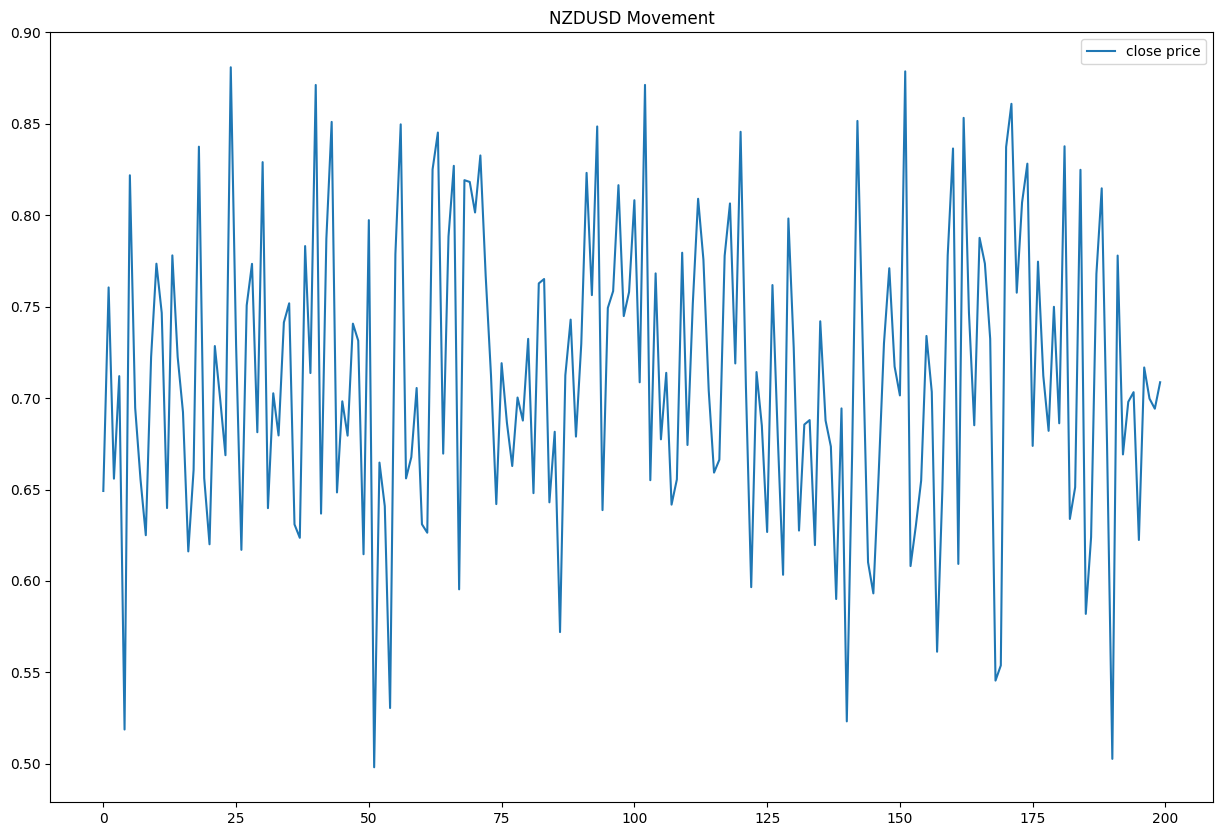

In [134]:
plt.figure(figsize=(15, 10))
plt.title(markets[n]+' Movement')
plt.plot(y_test[-200:], label="close price")
#plt.plot(x_test[-200:], label="open price")
plt.legend()
plt.show()

In [135]:
from sklearn.preprocessing import StandardScaler

sc_x = StandardScaler()
sc_y = StandardScaler()

x_train = sc_x.fit_transform(x_train)
y_train = sc_y.fit_transform(y_train.reshape((len(y_train),1)))
y_train = y_train.reshape(-1)

x_test = sc_x.transform(x_test)
y_test = sc_y.transform(y_test.reshape((len(y_test),1)))
y_test = y_test.reshape(-1)
print(x_train)
print(y_train)




[[0.26849 -1.23926]
 [-1.03631 0.33165]
 [-0.27158 -0.03144]
 ...
 [1.61706 0.12788]
 [0.91672 0.65028]
 [-0.71814 0.29399]]
[0.27108 -1.05793 -0.26941 ... 1.63339 0.91775 -0.71258]


In [136]:
timesteps = 1
samples = x_train.shape[0]
features = x_train.shape[1]

x_train = x_train[:samples*timesteps].reshape((samples, timesteps, features))

samples = x_test.shape[0]
features = x_test.shape[1]

x_test = x_test[:samples*timesteps].reshape((samples, timesteps, features))

print(x_train.shape)
print(x_test.shape)

(94999, 1, 2)
(4900, 1, 2)


In [137]:
print(x_train[0].shape)
print(x_test.shape)

(1, 2)
(4900, 1, 2)


In [138]:
i = Input(shape = x_train[0].shape)

X = LSTM(512, return_sequences=True)(i)
X = LSTM(256, return_sequences=True)(X)
X = LSTM(128, return_sequences=True)(X)
X = LSTM(128)(X)
X = Dense(128, activation="relu")(X)
X = Dense(1)(X)

model = Model(i, X)

model.compile(
    loss='mse',
    optimizer='adam'
)



r = model.fit(
    x_train,y_train,
    batch_size = 2048,
    epochs = 1000,
    validation_data = (x_test, y_test)

)

Epoch 1/1000
47/47 [==============================] - 13s 54ms/step - loss: 0.4261 - val_loss: 0.0229
Epoch 2/1000
47/47 [==============================] - 1s 17ms/step - loss: 0.0103 - val_loss: 0.0054
Epoch 3/1000
47/47 [==============================] - 1s 15ms/step - loss: 0.0034 - val_loss: 0.0019
Epoch 4/1000
47/47 [==============================] - 1s 15ms/step - loss: 0.0012 - val_loss: 7.2889e-04
Epoch 5/1000
47/47 [==============================] - 1s 15ms/step - loss: 5.4285e-04 - val_loss: 4.4411e-04
Epoch 6/1000
47/47 [==============================] - 1s 15ms/step - loss: 3.9053e-04 - val_loss: 3.7741e-04
Epoch 7/1000
47/47 [==============================] - 1s 14ms/step - loss: 3.4721e-04 - val_loss: 3.5089e-04
Epoch 8/1000
47/47 [==============================] - 1s 15ms/step - loss: 3.2606e-04 - val_loss: 3.3885e-04
Epoch 9/1000
47/47 [==============================] - 1s 13ms/step - loss: 3.1278e-04 - val_loss: 3.2977e-04
Epoch 10/1000
47/47 [=========================

In [139]:
def r_squared(y_true, y_pred):
  """Calculates the R-squared score.

  Args:
    y_true: The ground truth values.
    y_pred: The predicted values.

  Returns:
    The R-squared score.
  """

  mean_y_true = np.mean(y_true)
  ss_tot = np.sum((y_true - mean_y_true)**2)
  ss_res = np.sum((y_true - y_pred)**2)
  r_squared = 1 - ss_res / ss_tot
  return r_squared

y_pred = model.predict(x_test)
y_pred = y_pred.reshape(-1)
r_squared = r_squared(y_test[-100:], y_pred[-100:])

print(r_squared)

154/154 [==============================] - 3s 5ms/step
0.9998846274771557


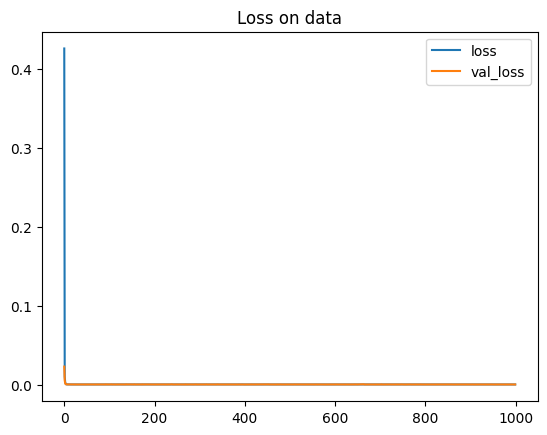

In [140]:
plt.title("Loss on data")
plt.plot(r.history['loss'], label="loss")
plt.plot(r.history['val_loss'], label="val_loss")
plt.legend()
plt.show()

In [141]:
y_test = sc_y.inverse_transform(y_test.reshape((len(y_test),1)))
y_pred = model.predict(x_test)
y_pred = sc_y.inverse_transform(y_pred.reshape((len(y_pred),1)))

154/154 [==============================] - 1s 5ms/step


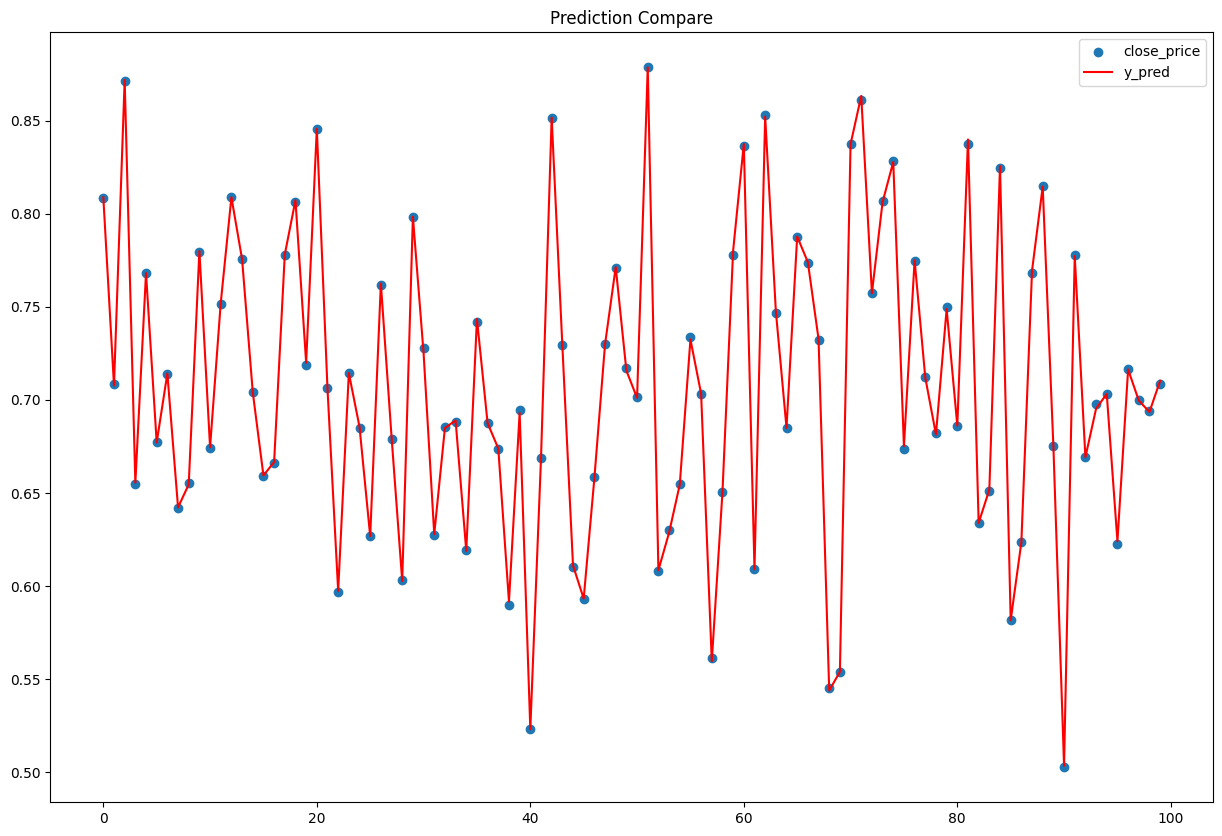

In [142]:
plt.figure(figsize=(15, 10))
plt.title("Prediction Compare")
x_point = []

for i in range(len(y_test[-100:])):
  t = [i]
  x_point.append(t)
plt.scatter(x_point, y_test[-100:], label="close_price")
#plt.plot(y_test, label="y_test")

plt.plot(y_pred[-100:], label="y_pred", color="red")

plt.legend()

plt.show()

In [143]:
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 1, 2)]            0         
                                                                 
 lstm_24 (LSTM)              (None, 1, 512)            1054720   
                                                                 
 lstm_25 (LSTM)              (None, 1, 256)            787456    
                                                                 
 lstm_26 (LSTM)              (None, 1, 128)            197120    
                                                                 
 lstm_27 (LSTM)              (None, 128)               131584    
                                                                 
 dense_12 (Dense)            (None, 128)               16512     
                                                                 
 dense_13 (Dense)            (None, 1)                 129 

In [144]:
model.save("/content/drive/MyDrive/forex data/"+markets[n]+".h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [145]:
import joblib

joblib.dump(sc_x, '/content/drive/MyDrive/forex data/'+markets[n]+ ' sc_x.joblib')
joblib.dump(sc_y, '/content/drive/MyDrive/forex data/'+markets[n]+ ' sc_y.joblib')

['/content/drive/MyDrive/forex data/NZDUSD sc_y.joblib']

In [ ]:
!pip install onnxruntime
!pip install onnxmltools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 32.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.5/322.5 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 51.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.7/294.7 kB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 62.9 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
orbax-checkpoint 0.3.

In [ ]:
!pip install -U tf2onnx
!pip install git+https://github.com/onnx/tensorflow-onnx
!git clone https://github.com/onnx/tensorflow-onnx
!python tensorflow-onnx/setup.py install


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.7/454.7 kB 7.7 MB/s eta 0:00:00
  Cloning https://github.com/onnx/tensorflow-onnx to /tmp/pip-req-build-pg57edve
  Running command git clone --filter=blob:none --quiet https://github.com/onnx/tensorflow-onnx /tmp/pip-req-build-pg57edve
  Resolved https://github.com/onnx/tensorflow-onnx to commit b57fe915b3728fbf996b490170a374821dd8383a
  Preparing metadata (setup.py) ... done
Cloning into 'tensorflow-onnx'...
remote: Enumerating objects: 16014, done.
remote: Counting objects: 100% (2211/2211), done.
remote: Compressing objects: 100% (181/181), done.
remote: Total 16014 (delta 2069), reused 2079 (delta 2022), pack-reused 13803
Receiving objects: 100% (16014/16014), 26.84 MiB | 27.42 MiB/s, done.
Resolving deltas: 100% (12188/12188), done.
/usr/local/lib/python3.10/dist-packages/setuptools/__init__.py:84: _DeprecatedInstaller: setuptools.installer and fetch_build_eggs are deprecated.
!!

        ********************************************

In [ ]:

from tensorflow.keras.models import load_model

model_list = [
    '/content/drive/MyDrive/forex data/metatrader 5 data H1/AUDUSD 1695376800.0.keras',
    '/content/drive/MyDrive/forex data/metatrader 5 data H1/EURGBP 1695376800.0.keras',
    '/content/drive/MyDrive/forex data/metatrader 5 data H1/EURUSD 1695376800.0.keras',
    '/content/drive/MyDrive/forex data/metatrader 5 data H1/GBPUSD 1695376800.0.keras',
    '/content/drive/MyDrive/forex data/metatrader 5 data H1/USDCAD 1695376800.0.keras',
    '/content/drive/MyDrive/forex data/metatrader 5 data H1/USDCHF 1695376800.0.keras',
    '/content/drive/MyDrive/forex data/metatrader 5 data H1/XAUUSD 1695362400.0.keras',
    "/content/drive/MyDrive/forex data/dbot_model.keras"
  ]

for target_list in model_list:
  # Load the Keras model
  model = load_model(target_list)
  model.save(target_list+".h5")
  # Convert the Keras model to ONNX
  #onnx_model = ox.convert_keras(model)

  # Save the ONNX model
  #onnx.save_model(onnx_model, target_list+'.onnx')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import keras
import tensorflow as tf
print("Keras version:", keras.__version__)
print("TensorFlow version:", tf.__version__)

Keras version: 2.13.1
TensorFlow version: 2.13.0
